<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [99]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Datos
Voy a utilizar un dataset con canciones de Coldplay.

In [101]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/ColdPlay.csv', sep='\n', header=None)
df.head()

,0
0,come up to meet you tell you i'm sorry you don...
1,i used to rule the world seas would rise when...
2,when you try your best but you don't succeed ...
3,look at the stars look how they shine for you...
4,and said drink from me drink from me ohahohah ...


In [102]:
df.head()

,0
0,come up to meet you tell you i'm sorry you don...
1,i used to rule the world seas would rise when...
2,when you try your best but you don't succeed ...
3,look at the stars look how they shine for you...
4,and said drink from me drink from me ohahohah ...


In [103]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

#### Preprocesamiento
Transformar el dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [104]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     come up to meet you tell you i'm sorry you don...
1      i used to rule the world seas would rise when...
2      when you try your best but you don't succeed ...
3      look at the stars look how they shine for you...
4     and said drink from me drink from me ohahohah ...
5     'cause you're a sky 'cause you're a sky full o...
6     oh they say people come say people go this par...
7     indecipherable   turn your magic on umi she'd ...
8       choir moses martin i want to know when i can...
9     oohoohooh oohoohooh oohoohooh oohoohooh oohooh...
10    call it magic call it true i call it magic whe...
11    the lights go out and i can't be saved tides t...
12    daddy are you out there daddy won't you come a...
13    what in the world are we going to do look at w...
14    did i drive you away i know what you'll say yo...
15     fixing up a car driving it again searching fo...
Name: 0, dtype: object

In [105]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

"come up to meet you tell you i'm sorry you don't know how lovely you are i had to find you tell you i need you tell you i set you apart tell me your secrets and ask me your questions oh let's go back to the start running in circles coming up tails heads on a science apart   nobody said it was easy it's such a shame for us to part nobody said it was easy no one ever said it would be this hard oh take me back to the start   i was just guessing at numbers and figures pulling the puzzles apart questions of science science and progress do not speak as loud as my heart tell me you love me come back and haunt me oh and i rush to the start running in circles chasing our tails coming back as we are   nobody said it was easy oh it's such a shame for us to part nobody said it was easy no one ever said it would be so hard i'm going back to the start   ohooh oohoohoohooh ahooh oohoohoohooh ohooh oohoohoohooh ohooh oohoohoohooh  i used to rule the world seas would rise when i gave the word now in t

In [106]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['come',
 'up',
 'to',
 'meet',
 'you',
 'tell',
 'you',
 "i'm",
 'sorry',
 'you',
 "don't",
 'know',
 'how',
 'lovely',
 'you',
 'are',
 'i',
 'had',
 'to',
 'find']

In [107]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 62323


In [108]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [109]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['come', 'up', 'to', 'meet'],
 ['up', 'to', 'meet', 'you'],
 ['to', 'meet', 'you', 'tell'],
 ['meet', 'you', 'tell', 'you'],
 ['you', 'tell', 'you', "i'm"],
 ['tell', 'you', "i'm", 'sorry'],
 ['you', "i'm", 'sorry', 'you'],
 ["i'm", 'sorry', 'you', "don't"],
 ['sorry', 'you', "don't", 'know'],
 ['you', "don't", 'know', 'how'],
 ["don't", 'know', 'how', 'lovely'],
 ['know', 'how', 'lovely', 'you'],
 ['how', 'lovely', 'you', 'are'],
 ['lovely', 'you', 'are', 'i'],
 ['you', 'are', 'i', 'had'],
 ['are', 'i', 'had', 'to'],
 ['i', 'had', 'to', 'find'],
 ['had', 'to', 'find', 'you'],
 ['to', 'find', 'you', 'tell'],
 ['find', 'you', 'tell', 'you']]

In [110]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[40, 28, 6, 315],
 [28, 6, 315, 2],
 [6, 315, 2, 126],
 [315, 2, 126, 2],
 [2, 126, 2, 21],
 [126, 2, 21, 622],
 [2, 21, 622, 2],
 [21, 622, 2, 20],
 [622, 2, 20, 26],
 [2, 20, 26, 44],
 [20, 26, 44, 1097],
 [26, 44, 1097, 2],
 [44, 1097, 2, 43],
 [1097, 2, 43, 1],
 [2, 43, 1, 217],
 [43, 1, 217, 6],
 [1, 217, 6, 117],
 [217, 6, 117, 2],
 [6, 117, 2, 126],
 [117, 2, 126, 2]]

In [111]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 62319


#### Input y target

In [112]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(62319, 3)
(62319,)


In [113]:
# Palabras del vocabulario
tok.index_word

{1: 'i',
 2: 'you',
 3: 'the',
 4: 'and',
 5: 'a',
 6: 'to',
 7: 'oh',
 8: 'in',
 9: 'me',
 10: 'it',
 11: 'my',
 12: 'of',
 13: 'on',
 14: 'your',
 15: 'for',
 16: 'be',
 17: 'so',
 18: 'all',
 19: 'that',
 20: "don't",
 21: "i'm",
 22: 'just',
 23: 'when',
 24: 'but',
 25: 'is',
 26: 'know',
 27: 'we',
 28: 'up',
 29: 'go',
 30: 'get',
 31: "it's",
 32: 'love',
 33: 'see',
 34: 'yeah',
 35: 'this',
 36: 'do',
 37: 'no',
 38: 'was',
 39: 'what',
 40: 'come',
 41: 'if',
 42: 'down',
 43: 'are',
 44: 'how',
 45: "you're",
 46: 'they',
 47: 'can',
 48: 'la',
 49: 'world',
 50: 'gonna',
 51: 'never',
 52: 'one',
 53: 'want',
 54: 'like',
 55: 'now',
 56: 'with',
 57: 'feel',
 58: 'will',
 59: 'say',
 60: 'out',
 61: 'not',
 62: 'got',
 63: 'as',
 64: 'from',
 65: 'light',
 66: "i'll",
 67: 'could',
 68: 'where',
 69: 'talk',
 70: 'ever',
 71: 'her',
 72: 'going',
 73: 'she',
 74: 'wanna',
 75: 'let',
 76: 'high',
 77: 'time',
 78: 'way',
 79: 'every',
 80: "can't",
 81: 'there',
 82: 'hav

In [114]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3616

In [115]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(62319, 3616)

## PRUEBA 1 - Modelo visto en clase

a) Entrenar el modelo

In [148]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [149]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3616

In [150]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3, 5)              18085     
                                                                 
 lstm_6 (LSTM)               (None, 3, 64)             17920     
                                                                 
 dropout_3 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 3616)              119328    
                                                                 
Total params: 190,437
Trainable params: 190,437
Non-tr

In [151]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
1558/1558 [==============================] - 18s 10ms/step - loss: 6.3835 - accuracy: 0.0359 - val_loss: 6.0184 - val_accuracy: 0.0400
Epoch 2/50
1558/1558 [==============================] - 13s 8ms/step - loss: 6.0881 - accuracy: 0.0380 - val_loss: 5.8000 - val_accuracy: 0.0557
Epoch 3/50
1558/1558 [==============================] - 14s 9ms/step - loss: 5.8198 - accuracy: 0.0466 - val_loss: 5.6189 - val_accuracy: 0.0560
Epoch 4/50
1558/1558 [==============================] - 15s 9ms/step - loss: 5.6035 - accuracy: 0.0555 - val_loss: 5.5033 - val_accuracy: 0.0612
Epoch 5/50
1558/1558 [==============================] - 12s 8ms/step - loss: 5.4498 - accuracy: 0.0654 - val_loss: 5.4165 - val_accuracy: 0.0628
Epoch 6/50
1558/1558 [==============================] - 13s 9ms/step - loss: 5.3044 - accuracy: 0.0764 - val_loss: 5.3334 - val_accuracy: 0.0690
Epoch 7/50
1558/1558 [==============================] - 13s 9ms/step - loss: 5.1572 - accuracy: 0.0906 - val_loss: 5.2383 - val_a

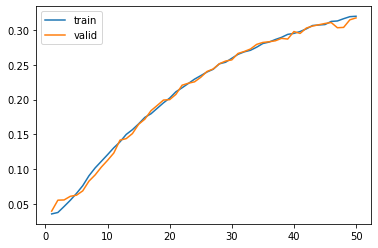

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

b) Predicción de próxima palabra

In [153]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [154]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [34]:
#import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word


In [156]:
# Frase de la canción "nobody said it was easy"
model_response('nobody said it was')

1/1 [==============================] - 1s 911ms/step


'nobody said it was careful'

In [157]:
# Frase original: "tell me you love me"
model_response('tell me you')

1/1 [==============================] - 0s 19ms/step


'tell me you that'

In [158]:
# Frase original: "Your skin, oh yeah, your skin and bones"
model_response('your skin and')

1/1 [==============================] - 0s 16ms/step


'your skin and whisper'

In [159]:
# Frase original: "And it was all yellow"
model_response('it was all')

1/1 [==============================] - 0s 23ms/step


'it was all lie'

In [160]:
# Frase original: "And the hardest part was letting go, not taking part"
model_response('the hardest part was')

1/1 [==============================] - 0s 17ms/step


'the hardest part was ohoh'

In [161]:
# Frase original: "You really broke my heart, oh"
model_response('You really broke my')

1/1 [==============================] - 0s 19ms/step


'You really broke my look'

c) Generación de secuencias nuevas

In [162]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [163]:
input_text='I will try'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 15ms/step


'I will try a somewhere'

## PRUEBA 2 - Mismo corpus, mismo modelo, aumento la cantidad de epochs a 100

a) Entrenar el modelo

In [164]:
hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
1558/1558 [==============================] - 20s 13ms/step - loss: 3.1968 - accuracy: 0.3214 - val_loss: 4.8595 - val_accuracy: 0.3188
Epoch 2/100
1558/1558 [==============================] - 13s 8ms/step - loss: 3.1876 - accuracy: 0.3236 - val_loss: 4.8979 - val_accuracy: 0.3178
Epoch 3/100
1558/1558 [==============================] - 15s 10ms/step - loss: 3.1795 - accuracy: 0.3271 - val_loss: 4.9194 - val_accuracy: 0.3218
Epoch 4/100
1558/1558 [==============================] - 13s 8ms/step - loss: 3.1542 - accuracy: 0.3296 - val_loss: 4.9245 - val_accuracy: 0.3155
Epoch 5/100
1558/1558 [==============================] - 14s 9ms/step - loss: 3.1504 - accuracy: 0.3310 - val_loss: 4.8805 - val_accuracy: 0.3291
Epoch 6/100
1558/1558 [==============================] - 15s 10ms/step - loss: 3.1397 - accuracy: 0.3316 - val_loss: 4.8837 - val_accuracy: 0.3241
Epoch 7/100
1558/1558 [==============================] - 15s 9ms/step - loss: 3.1270 - accuracy: 0.3347 - val_loss: 4.869

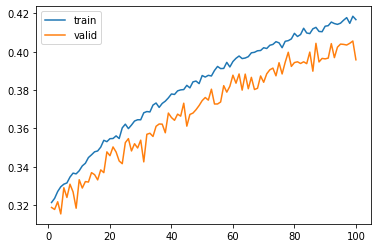

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

b) Predicción de próxima palabra

In [167]:
# Frase de la canción "nobody said it was easy"
model_response('nobody said it was')

1/1 [==============================] - 0s 72ms/step


'nobody said it was careful'

In [168]:
# Frase original: "tell me you love me"
model_response('tell me you')

1/1 [==============================] - 0s 17ms/step


'tell me you good'

In [169]:
# Frase original: "Your skin, oh yeah, your skin and bones"
model_response('your skin and')

1/1 [==============================] - 0s 18ms/step


'your skin and whisper'

In [170]:
# Frase original: "And it was all yellow"
model_response('it was all')

1/1 [==============================] - 0s 18ms/step


'it was all lie'

In [171]:
# Frase original: "And the hardest part was letting go, not taking part"
model_response('the hardest part was')

1/1 [==============================] - 0s 18ms/step


'the hardest part was tree'

In [172]:
# Frase original: "You really broke my heart, oh"
model_response('You really broke my')

1/1 [==============================] - 0s 17ms/step


'You really broke my look'

c) Generación de secuencias nuevas

In [173]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [174]:
input_text='I will try'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 17ms/step


'I will try a soon'

### PRUEBA 3 - Aumento p de dropout a 0.3 para ver si mejora el problema del overfitting

In [116]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [117]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3616

In [118]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 5)              18085     
                                                                 
 lstm_4 (LSTM)               (None, 3, 64)             17920     
                                                                 
 dropout_2 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3616)              119328    
                                                                 
Total params: 190,437
Trainable params: 190,437
Non-tr

In [119]:
hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
1558/1558 [==============================] - 32s 17ms/step - loss: 6.3827 - accuracy: 0.0352 - val_loss: 6.0060 - val_accuracy: 0.0400
Epoch 2/100
1558/1558 [==============================] - 25s 16ms/step - loss: 6.0810 - accuracy: 0.0379 - val_loss: 5.7797 - val_accuracy: 0.0406
Epoch 3/100
1558/1558 [==============================] - 24s 15ms/step - loss: 5.7993 - accuracy: 0.0467 - val_loss: 5.6214 - val_accuracy: 0.0570
Epoch 4/100
1558/1558 [==============================] - 24s 15ms/step - loss: 5.5867 - accuracy: 0.0550 - val_loss: 5.4953 - val_accuracy: 0.0536
Epoch 5/100
1558/1558 [==============================] - 23s 15ms/step - loss: 5.4165 - accuracy: 0.0688 - val_loss: 5.3863 - val_accuracy: 0.0660
Epoch 6/100
1558/1558 [==============================] - 24s 15ms/step - loss: 5.2638 - accuracy: 0.0805 - val_loss: 5.2984 - val_accuracy: 0.0784
Epoch 7/100
1558/1558 [==============================] - 26s 17ms/step - loss: 5.1195 - accuracy: 0.0931 - val_loss: 5

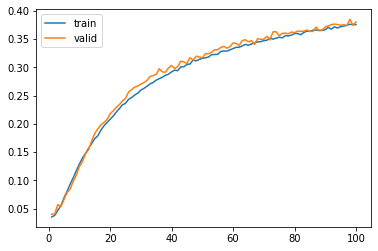

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

b) Predicción de próxima palabra

In [123]:
# Frase de la canción "nobody said it was easy"
model_response('nobody said it was')

1/1 [==============================] - 0s 20ms/step


'nobody said it was careful'

In [124]:
# Frase original: "tell me you love me"
model_response('tell me you')

1/1 [==============================] - 0s 42ms/step


'tell me you dry'

In [125]:
# Frase original: "Your skin, oh yeah, your skin and bones"
model_response('your skin and')

1/1 [==============================] - 0s 24ms/step


'your skin and whisper'

In [126]:
# Frase original: "And it was all yellow"
model_response('it was all')

1/1 [==============================] - 0s 22ms/step


'it was all lie'

In [127]:
# Frase original: "And the hardest part was letting go, not taking part"
model_response('the hardest part was')

1/1 [==============================] - 0s 26ms/step


'the hardest part was tree'

In [128]:
# Frase original: "You really broke my heart, oh"
model_response('You really broke my')

1/1 [==============================] - 0s 22ms/step


'You really broke my look'

c) Generación de secuencias nuevas

In [129]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [130]:
input_text='I will try'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 20ms/step


'I will try a rough'

### PRUEBA 4 - Remuevo stop-words

In [16]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 62323


In [18]:
# Para remover las stop-words voy a usar NLTK
import nltk
import string
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords

# Descargar tokenizador punkt
nltk.download("punkt")
# Descargar diccionario de inglés
nltk.download("wordnet")
# Descargar diccionario de stopwords
nltk.download('stopwords')
# Para usar NLTK 3.6.6 o superior es necesario instalar OMW 1.4 
# (Open Multilingual WordNet)
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [19]:
# Stop words
nltk_stop_words = set(stopwords.words("english"))
tokens = [w for w in tokens if w not in nltk_stop_words]
# Quitar los signos de puntuacion
tokens = [w for w in tokens if w not in string.punctuation]
print("Resultado:", tokens)

Resultado: ['come', 'meet', 'tell', "i'm", 'sorry', 'know', 'lovely', 'find', 'tell', 'need', 'tell', 'set', 'apart', 'tell', 'secrets', 'ask', 'questions', 'oh', "let's", 'go', 'back', 'start', 'running', 'circles', 'coming', 'tails', 'heads', 'science', 'apart', 'nobody', 'said', 'easy', 'shame', 'us', 'part', 'nobody', 'said', 'easy', 'one', 'ever', 'said', 'would', 'hard', 'oh', 'take', 'back', 'start', 'guessing', 'numbers', 'figures', 'pulling', 'puzzles', 'apart', 'questions', 'science', 'science', 'progress', 'speak', 'loud', 'heart', 'tell', 'love', 'come', 'back', 'haunt', 'oh', 'rush', 'start', 'running', 'circles', 'chasing', 'tails', 'coming', 'back', 'nobody', 'said', 'easy', 'oh', 'shame', 'us', 'part', 'nobody', 'said', 'easy', 'one', 'ever', 'said', 'would', 'hard', "i'm", 'going', 'back', 'start', 'ohooh', 'oohoohoohooh', 'ahooh', 'oohoohoohooh', 'ohooh', 'oohoohoohooh', 'ohooh', 'oohoohoohooh', 'used', 'rule', 'world', 'seas', 'would', 'rise', 'gave', 'word', 'mornin

In [20]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [21]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['come', 'meet', 'tell', "i'm"],
 ['meet', 'tell', "i'm", 'sorry'],
 ['tell', "i'm", 'sorry', 'know'],
 ["i'm", 'sorry', 'know', 'lovely'],
 ['sorry', 'know', 'lovely', 'find'],
 ['know', 'lovely', 'find', 'tell'],
 ['lovely', 'find', 'tell', 'need'],
 ['find', 'tell', 'need', 'tell'],
 ['tell', 'need', 'tell', 'set'],
 ['need', 'tell', 'set', 'apart'],
 ['tell', 'set', 'apart', 'tell'],
 ['set', 'apart', 'tell', 'secrets'],
 ['apart', 'tell', 'secrets', 'ask'],
 ['tell', 'secrets', 'ask', 'questions'],
 ['secrets', 'ask', 'questions', 'oh'],
 ['ask', 'questions', 'oh', "let's"],
 ['questions', 'oh', "let's", 'go'],
 ['oh', "let's", 'go', 'back'],
 ["let's", 'go', 'back', 'start'],
 ['go', 'back', 'start', 'running']]

In [22]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[9, 234, 65, 2],
 [234, 65, 2, 511],
 [65, 2, 511, 3],
 [2, 511, 3, 977],
 [511, 3, 977, 59],
 [3, 977, 59, 65],
 [977, 59, 65, 92],
 [59, 65, 92, 65],
 [65, 92, 65, 253],
 [92, 65, 253, 235],
 [65, 253, 235, 65],
 [253, 235, 65, 785],
 [235, 65, 785, 284],
 [65, 785, 284, 847],
 [785, 284, 847, 1],
 [284, 847, 1, 71],
 [847, 1, 71, 4],
 [1, 71, 4, 48],
 [71, 4, 48, 136],
 [4, 48, 136, 451]]

In [23]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 32432


#### Input y target

In [24]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(32432, 3)
(32432,)


In [25]:
# Palabras del vocabulario
tok.index_word

{1: 'oh',
 2: "i'm",
 3: 'know',
 4: 'go',
 5: 'get',
 6: 'love',
 7: 'see',
 8: 'yeah',
 9: 'come',
 10: 'la',
 11: 'world',
 12: 'gonna',
 13: 'never',
 14: 'one',
 15: 'want',
 16: 'like',
 17: 'feel',
 18: 'say',
 19: 'got',
 20: 'light',
 21: "i'll",
 22: 'could',
 23: 'talk',
 24: 'ever',
 25: 'going',
 26: 'wanna',
 27: 'let',
 28: 'high',
 29: 'time',
 30: 'way',
 31: 'every',
 32: "can't",
 33: "'cause",
 34: 'woo',
 35: 'life',
 36: 'sky',
 37: 'always',
 38: 'eyes',
 39: 'look',
 40: 'heart',
 41: 'head',
 42: 'lost',
 43: 'something',
 44: "that's",
 45: 'us',
 46: 'day',
 47: 'away',
 48: 'back',
 49: 'ooh',
 50: 'paraparaparadise',
 51: 'shine',
 52: 'think',
 53: 'sing',
 54: 'ah',
 55: 'hear',
 56: 'give',
 57: 'together',
 58: 'home',
 59: 'find',
 60: 'waiting',
 61: 'said',
 62: 'sun',
 63: 'nothing',
 64: 'well',
 65: 'tell',
 66: 'around',
 67: 'take',
 68: 'fly',
 69: 'right',
 70: 'maybe',
 71: "let's",
 72: "i've",
 73: 'hoo',
 74: 'singing',
 75: 'sometimes',
 

In [26]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3476

In [27]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(32432, 3476)

a) Entrenar el modelo

In [28]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [29]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3476

In [30]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              17385     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3476)              114708    
                                                                 
Total params: 185,117
Trainable params: 185,117
Non-trai

In [31]:
hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
811/811 [==============================] - 18s 17ms/step - loss: 7.1286 - accuracy: 0.0261 - val_loss: 6.8218 - val_accuracy: 0.0362
Epoch 2/100
811/811 [==============================] - 12s 15ms/step - loss: 6.7904 - accuracy: 0.0300 - val_loss: 6.7837 - val_accuracy: 0.0376
Epoch 3/100
811/811 [==============================] - 12s 15ms/step - loss: 6.6456 - accuracy: 0.0321 - val_loss: 6.7183 - val_accuracy: 0.0373
Epoch 4/100
811/811 [==============================] - 14s 17ms/step - loss: 6.5119 - accuracy: 0.0334 - val_loss: 6.7086 - val_accuracy: 0.0375
Epoch 5/100
811/811 [==============================] - 19s 23ms/step - loss: 6.4047 - accuracy: 0.0378 - val_loss: 6.6666 - val_accuracy: 0.0359
Epoch 6/100
811/811 [==============================] - 16s 19ms/step - loss: 6.2905 - accuracy: 0.0424 - val_loss: 6.6388 - val_accuracy: 0.0362
Epoch 7/100
811/811 [==============================] - 13s 16ms/step - loss: 6.1778 - accuracy: 0.0466 - val_loss: 6.5950 - val_ac

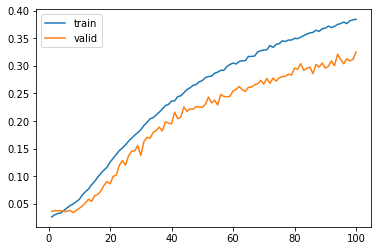

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

b) Predicción de próxima palabra

In [62]:
# Frase de la canción "nobody said it was easy"
model_response('nobody said')

1/1 [==============================] - 0s 21ms/step


'nobody said oh'

In [64]:
# Frase original: "tell me you love me"
model_response('tell')

1/1 [==============================] - 0s 42ms/step


'tell walking'

In [60]:
# Frase original: "Your skin, oh yeah, your skin and bones"
model_response('your skin')

1/1 [==============================] - 0s 20ms/step


'your skin know'

In [59]:
# Frase original: "And it was all yellow"
model_response('yellow')

1/1 [==============================] - 0s 44ms/step


'yellow read'

In [54]:
# Frase original: "And the hardest part was letting go, not taking part"
model_response('hardest')

1/1 [==============================] - 0s 31ms/step


'hardest things'

In [75]:
# Frase original: "You really broke my heart, oh"
model_response('you really broke my')

1/1 [==============================] - 0s 19ms/step


'you really broke my wood'

In [71]:
# Frase original: "When I'm rolling with the punches and hope is gone"
model_response('rolling')

1/1 [==============================] - 0s 20ms/step


'rolling backwards'

c) Generación de secuencias nuevas

In [41]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [52]:
input_text='paradise'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 80ms/step


'paradise soaks see'

### PRUEBA 5 - Modelo con redes bidireccionales

In [131]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [132]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3616

In [133]:
from keras.layers import Bidirectional
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)

model.add(Embedding(input_dim=vocab_size+1, output_dim=3, input_length=input_seq_len))

model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3)))
model.add(Bidirectional(LSTM(64, activation='relu')))

# Predicción de clasificación con softmax
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3, 3)              10851     
                                                                 
 bidirectional (Bidirectiona  (None, 3, 128)           34816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 3616)              466464    
                                                                 
Total params: 610,947
Trainable params: 610,947
Non-trainable params: 0
_________________________________________________________________


In [134]:
hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
1558/1558 [==============================] - 46s 25ms/step - loss: 6.3062 - accuracy: 0.0362 - val_loss: 5.8584 - val_accuracy: 0.0388
Epoch 2/100
1558/1558 [==============================] - 36s 23ms/step - loss: 5.9569 - accuracy: 0.0422 - val_loss: 5.6754 - val_accuracy: 0.0462
Epoch 3/100
1558/1558 [==============================] - 36s 23ms/step - loss: 5.7155 - accuracy: 0.0524 - val_loss: 5.5281 - val_accuracy: 0.0622
Epoch 4/100
1558/1558 [==============================] - 36s 23ms/step - loss: 5.5421 - accuracy: 0.0612 - val_loss: 5.4264 - val_accuracy: 0.0661
Epoch 5/100
1558/1558 [==============================] - 38s 24ms/step - loss: 5.4102 - accuracy: 0.0720 - val_loss: 5.3348 - val_accuracy: 0.0820
Epoch 6/100
1558/1558 [==============================] - 36s 23ms/step - loss: 5.2917 - accuracy: 0.0821 - val_loss: 5.2531 - val_accuracy: 0.0915
Epoch 7/100
1558/1558 [==============================] - 35s 23ms/step - loss: 5.1815 - accuracy: 0.0912 - val_loss: 5

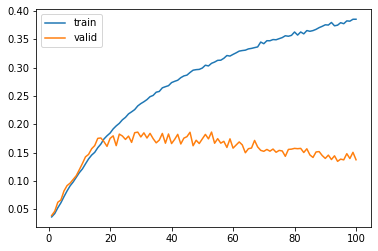

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

b) Predicción de próxima palabra

In [136]:
# Frase de la canción "nobody said it was easy"
model_response('nobody said')

1/1 [==============================] - 1s 1s/step


'nobody said the'

In [137]:
# Frase original: "tell me you love me"
model_response('tell')

1/1 [==============================] - 0s 24ms/step


'tell in'

In [138]:
# Frase original: "Your skin, oh yeah, your skin and bones"
model_response('your skin')

1/1 [==============================] - 0s 22ms/step


'your skin to'

In [139]:
# Frase original: "And it was all yellow"
model_response('yellow')

1/1 [==============================] - 0s 20ms/step


'yellow the'

In [140]:
# Frase original: "And the hardest part was letting go, not taking part"
model_response('hardest')

1/1 [==============================] - 0s 19ms/step


'hardest i'

In [141]:
# Frase original: "You really broke my heart, oh"
model_response('you really broke my')

1/1 [==============================] - 0s 20ms/step


"you really broke my it's"

In [142]:
# Frase original: "When I'm rolling with the punches and hope is gone"
model_response('rolling')

1/1 [==============================] - 0s 20ms/step


'rolling song'

c) Generación de secuencias nuevas

In [143]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [144]:
input_text='paradise'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 24ms/step


'paradise i he'

### Conclusiones:

Detalle de pruebas realizadas:

1. Red vista en clase. 2 x LSTM + 2 capas densas + dropout c/prob 0.2 y 50 epochs
2. Misma red pero aumento las epochs a 100.
3. Misma red, 100 epochs y aumento p de dropout a 0.3 (para atacar el problema de overfitting)
4. En este caso removí las stop-words con NLTK, y usé el mismo modelo que en las pruebas anteriores con 100 epochs.
5. Pruebo con LSTM bidireccional.


Los resultados de la prueba 1 mostraron un mal desempeño y overfitting. Al observar las curvas de accuracy para train y validation parecía que 50 epochs no era suficiente. Para la prueba 2, se aumentaron las epochs al doble, es decir a 100. En este caso la accuracy de train y validación mejora apenas (subió hasta aprox 0.4), pero sigue habiendo overfitting. Haciendo las pruebas se observa que algunos resultados cambian, sin embargo la performance sigue siendo pobre y los resultados no tienen sentido.
En la prueba 3 se subió la probabilidad de dropout a 0.3 para ver si producía alguna mejora con respecto al overfitting pero no hubo un cambio significativo en los resultados.
Al remover las stop-words (prueba 4), se obtiene una accuracy similar a la de las pruebas anteriores, pero al realizar las pruebas algunos de los resultados parecen ser mejores:

*   a) Input: "nobody said" - Output: "nobody said oh"
*   b) Input: "hardest" - Output: "hardest things"
*   c) Input: "rolling" - Output: "rolling backwards"

En este caso hice las pruebas evitando agregar stop-words como input, ya que no se tendrán en cuenta en la predicción.

Por último, se probó un modelo con redes LSTM bidireccionales, 100 epochs y dropout en 0.3. Nuevamente, los resultados fueron pobres.

En todos los casos, las pruebas de generación de secuencias nuevas con modelo autorregresivo arrojan malos resultados. Esto se debe a que se utilizan los modelos que no funcionan bien para ir prediciendo cada palabra de la secuencia y como resultado, se termina "propagando" el error.

Finalmente, se concluye que ninguno de los cambios produce un impacto significativo en los resultados principlamente porque el problema de performance está dado por el tamaño del dataset que no es adecuado (demasiado pequeño) para este tipo de problemas.  

